## I was asked: How might one plot biplot in a ternary diagram?
I'll be honest, this is the first time I've had to try plot PCA scores and loadings on a ternary diagram. I had to turn to the internet to learn more about this plot!  

I've found two papers that demonstrate this type of plot:  
- Kirkwood et al. (2016): https://doi.org/10.1016/j.gexplo.2016.01.010
- Wu et al. (2021): https://doi.org/10.1007/s11053-020-09788-z

In general, I'd caution that any potential user carefully review the logic and adjust for their particular workflow, before replicating. Hopefully this example is a useful.

Wu et al. (2021):

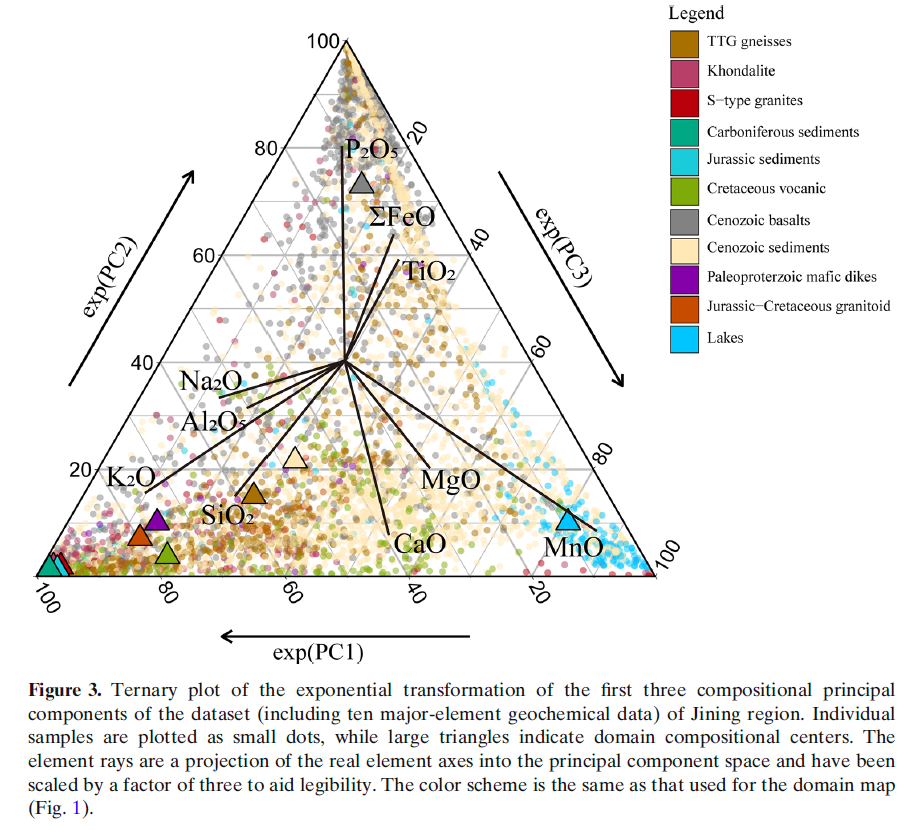


Kirkwood et al. (2016):

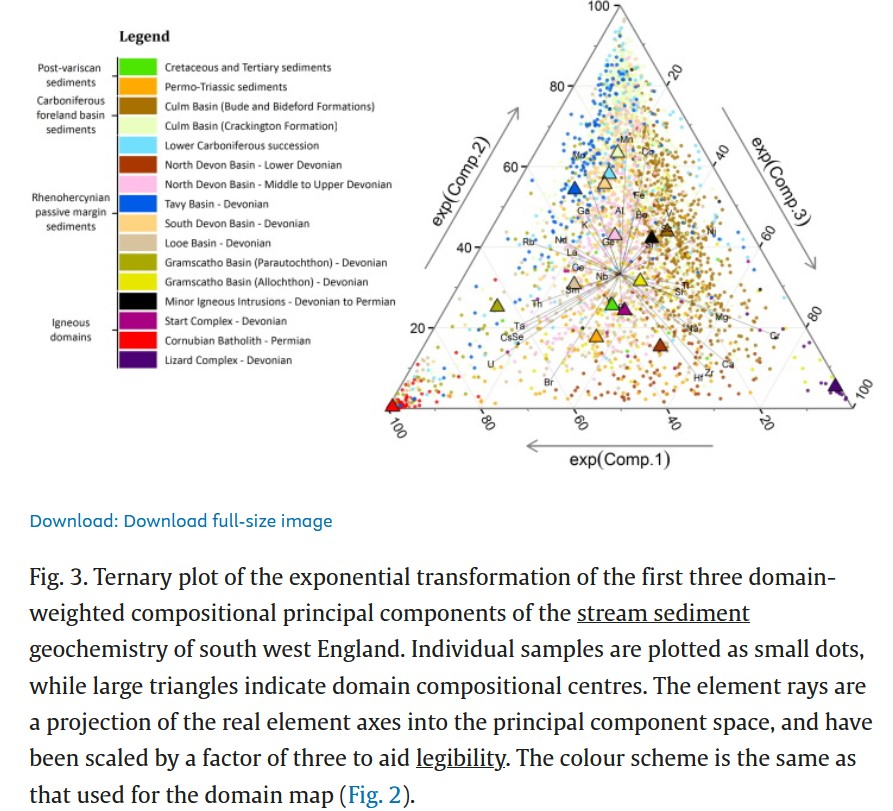

## Import libraries and create necessary functions

In [37]:
# Import the libraries needed:

import pandas as pd #for data manipulation
import numpy as np #for vectorised (fast) calculations
import matplotlib.pyplot as plt #for plotting
from pyrolite.comp.codata import CLR #centered log ratio transform, but could also use Scikit-bio
from sklearn.decomposition import PCA #for principal component analysis
from sklearn import preprocessing # this gives me access to standard scalar(), for normalising data prior to pca
import mpltern # for ternary plots

In [38]:
# Defining a function that will normalise my pca data for plotting on a ternary diagram

def prep_for_plotting(data_matrix):
    '''
    Applies explonentiation to ndarray of pca results, then normalises to sum to one.
    data_matrix: ndarray returned by scikit-learn pca.fit, or pca.loadings_
    '''
    #Exponentiate the PCA results using numpty
    exp_pca = np.exp(data_matrix)
    
    # Apply closure (get the 3 principal components to sum to 1, for the ternary diagram)
    # axis = 1 means sum along the rows, i.e. get the sum of PC's for a sample
    # keepdims = true returns results as a column, which allows it to be 'broadcast' in the calculation. Read about broadcasting here: https://numpy.org/doc/stable/user/basics.broadcasting.html
    # Read more here: https://numpy.org/doc/2.1/reference/generated/numpy.sum.html
    closed_pca = exp_pca / exp_pca.sum(axis=1, keepdims=True)

    return closed_pca

## Load the data

Unfortunately, neither of the papers listed above provide their actual datasets. I've therefore created a simple dataset from the data of Soares et al. (2018) - https://doi.org/10.1016/j.oregeorev.2018.09.028.  

1) Read the dataset by providing the file path to pandas.
2) Look for issues in the data and clean up if necessary. (This dataset is a nice clean dataset).

In [39]:
Pimentao_BIF = pd.read_csv(r"Simple_trace_element_dataset.csv", encoding='latin-1')

In [40]:
#Looking for absent values
Pimentao_BIF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ag_ppm  233 non-null    float64
 1   As_ppm  233 non-null    float64
 2   Bi_ppm  233 non-null    float64
 3   Cr_ppm  233 non-null    int64  
 4   Cu_ppm  233 non-null    float64
 5   Zn_ppm  233 non-null    float64
 6   S_ppm   233 non-null    float64
 7   W_ppm   233 non-null    float64
 8   Co_ppm  233 non-null    float64
 9   Ni_ppm  233 non-null    float64
 10  Te_ppm  233 non-null    float64
 11  Tl_ppm  233 non-null    float64
 12  Sb_ppm  233 non-null    float64
 13  Pb_ppm  233 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 25.6 KB


In [41]:
# Looking at dataframe summary statistics
Pimentao_BIF.describe()

,Ag_ppm,As_ppm,Bi_ppm,Cr_ppm,Cu_ppm,Zn_ppm,S_ppm,W_ppm,Co_ppm,Ni_ppm,Te_ppm,Tl_ppm,Sb_ppm,Pb_ppm
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,1.025803,503.168240,15.092403,66.819742,667.024592,190.212017,38611.588197,4.374249,15.134764,74.706867,0.703219,0.653433,0.366609,5.875107
std,1.023194,1048.627063,17.282943,30.501302,733.648448,147.596022,35142.990164,17.854448,10.594157,36.617354,0.695799,0.528711,0.319011,3.603931
min,0.033000,0.100000,0.170000,17.000000,4.280000,33.700000,1500.000000,0.100000,2.500000,14.000000,0.025000,0.025000,0.050000,1.310000
25%,0.079000,2.600000,1.510000,44.000000,38.360000,77.800000,3500.000000,0.300000,8.800000,51.000000,0.190000,0.300000,0.150000,3.120000
50%,0.600000,36.000000,9.860000,64.000000,283.260000,137.100000,30400.000000,0.500000,13.000000,74.100000,0.450000,0.480000,0.260000,4.970000
75%,1.935000,517.100000,23.580000,86.000000,1288.160000,275.800000,75100.000000,1.600000,18.300000,92.500000,0.990000,0.870000,0.500000,7.270000
max,4.512000,7251.000000,112.790000,204.000000,2887.750000,894.700000,100000.000000,200.000000,81.300000,221.500000,3.600000,2.820000,2.190000,25.160000


## Perform Principal Component Analysis

Three steps are performed:  
1) Log-ratio transform. This is either a centered log ratio transform or an isometric log ratio transform. It is up to the data analyst to choose the appropriate method.
2) Standardise the data to have a mean of zero and a standard deviation of 1.
3) Principal component analysis.

In [42]:
# 1 - Center log ratio transform the data
Pimentao_clr = CLR(Pimentao_BIF)

In [43]:
# 2 - Ccale the data to mean of zero and unit variance
scaler = preprocessing.StandardScaler()
scaled_clr = scaler.fit_transform(Pimentao_clr)

In [44]:
# 3 - Perform principal component analysis
pca = PCA(n_components=3) # only interested in the first three principal components for this plot
pimentao_PCA = pca.fit_transform(scaled_clr) #fit pca model and transform the data, returns ndarray of shape (n_samples, n_components)

## Prepare data for plotting:

1) Prepare the PCA scores for plotting
2) Prepare the PCA loadings for plotting

In [45]:
# 1 - Prepare PCA scores for plotting

pca_norm = prep_for_plotting(pimentao_PCA)
pca_df = pd.DataFrame(pca_norm, columns=['PC1', 'PC2', 'PC3']) #convert ndarry into a dataframe for easy manipulation
pca_df.head()

,PC1,PC2,PC3
0,0.866457,0.005389,0.128154
1,0.587126,0.054777,0.358096
2,0.436657,0.144712,0.418631
3,0.323290,0.096160,0.580550
4,0.409276,0.031899,0.558825


In [46]:
# 2 - Prepare the PCA loadings for plotting

loadings = pca.components_ #returns ndarray of shape n_components (PC's), n_features (elements)
loadings_transformed = loadings.T # transposes rows and columns, so the data is now in shape of n_features, n_components (PC's are columns)
loadings_norm =  prep_for_plotting(loadings_transformed)

#create a dataframe from normalised loadings
variable_labels = [element.split('_')[0] for element in Pimentao_BIF.columns]
loadings_df = pd.DataFrame(loadings_norm, #convert ndarry into a dataframe for easy manipulation
                                index=variable_labels, #use the elements as dataframe indices
                                columns=['PC1', 'PC2', 'PC3'])
loadings_df.head()

,PC1,PC2,PC3
Ag,0.411282,0.307218,0.281500
As,0.318038,0.276712,0.405250
Bi,0.395131,0.276498,0.328371
Cr,0.225811,0.418738,0.355450
Cu,0.418770,0.336970,0.244260


## Plot the ternary diagram

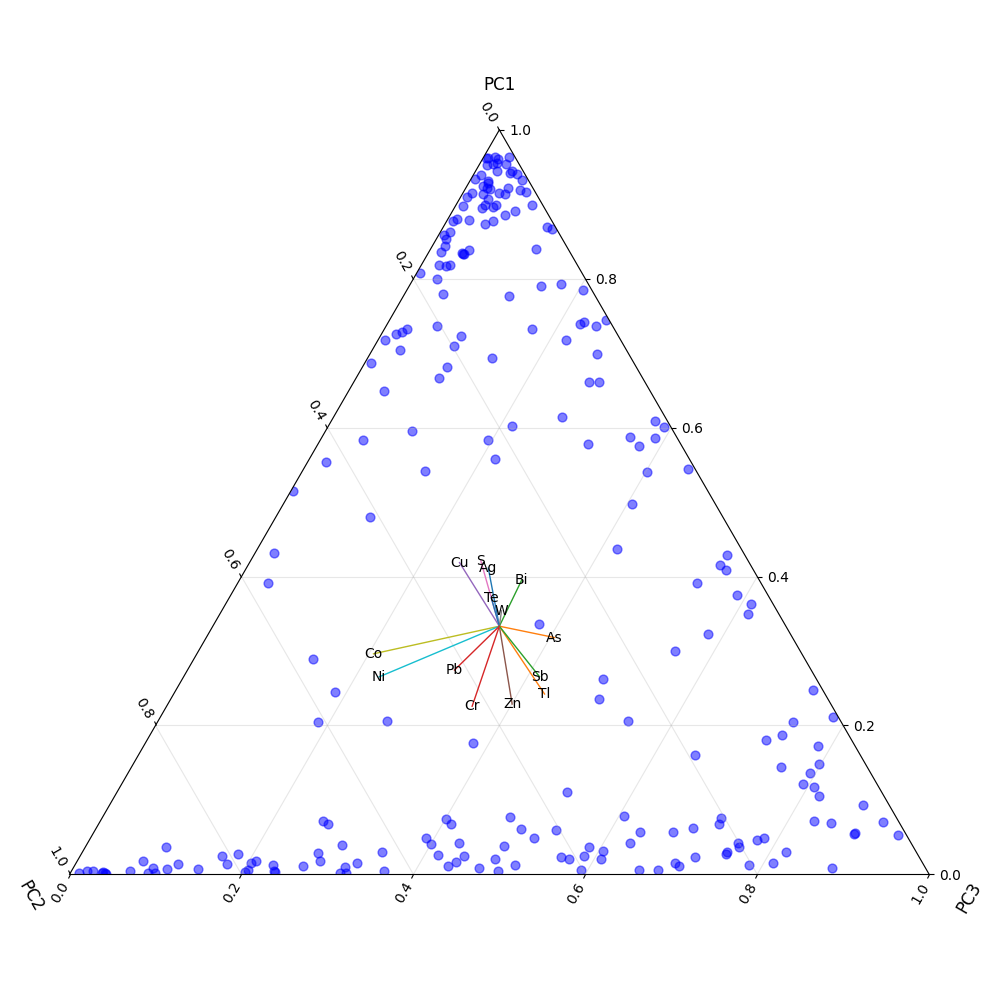

In [48]:
# Create the figure and axis on which to plot

fig = plt.figure(figsize=(10, 10)) #create a figure with matplotlib
ax = fig.add_subplot(1, 1, 1, projection="ternary") #assign a ternary projection with mpltern

# Plot the PCA scores
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c='blue', alpha=0.5, marker = 'o', s = 40) #plot the PCA scores

# Plot the PCA loadings
for element in loadings_df.index: #get the list of elements to plot
    top = loadings_df.loc[element, 'PC1']
    left = loadings_df.loc[element, 'PC2']
    right = loadings_df.loc[element, 'PC3']

    ax.plot([1/3, top], [1/3, left], [1/3, right])
    ax.text(top, left, right, element, ha='center', va='center', fontsize=10)
ax.set_tlabel("PC1")
ax.set_llabel("PC2")
ax.set_rlabel("PC3")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

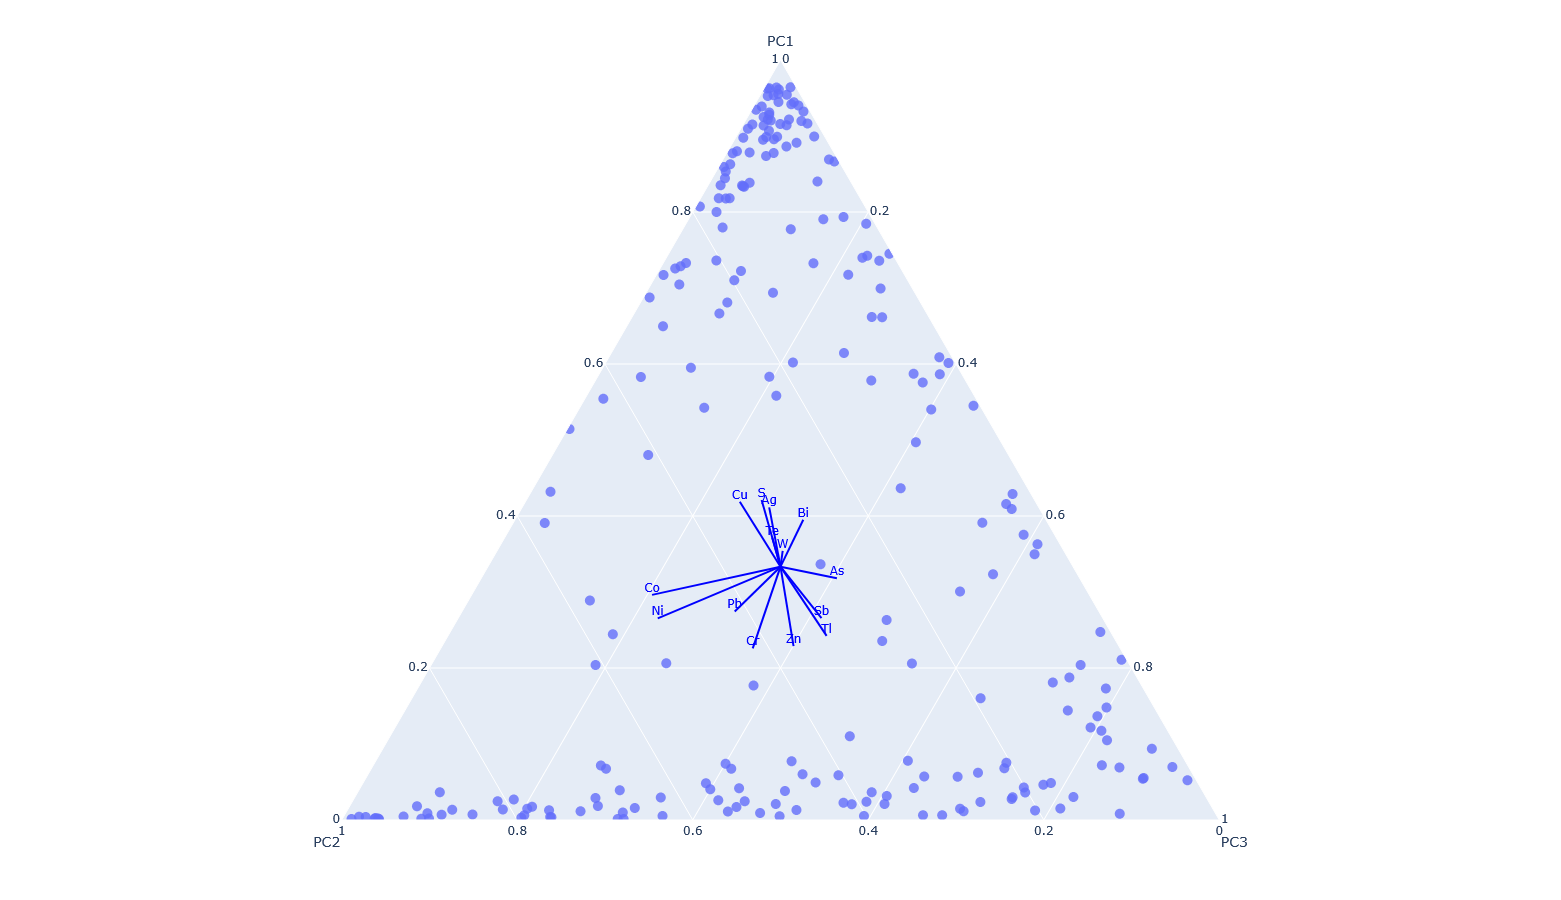

In [65]:
# Repeating the plot using plotly instead of mpltern, which has nice interactive capability.

import plotly.express as px

fig = px.scatter_ternary(
    pca_df, 
    a='PC1', 
    b='PC2', 
    c='PC3',
    width = 900,
    height = 900
)

loading_traces = []
for element in loadings_df.index:
    loading_a = loadings_df.loc[element, 'PC1']
    loading_b = loadings_df.loc[element, 'PC2']
    loading_c = loadings_df.loc[element, 'PC3']

    fig.add_trace(
        dict(
            type='scatterternary',
            mode='lines',
            a=[1/3, loading_a],
            b=[1/3, loading_b],
            c=[1/3, loading_c],
            line=dict(color='blue', width=2),
            showlegend=False
        )
    )

    fig.add_trace(
        dict(
            type='scatterternary',
            mode='text',
            a=[loading_a],
            b=[loading_b],
            c=[loading_c],
            text=[element],
            textposition='top center',
            showlegend=False,
            textfont=dict(size=12, color='blue')
        )
    )
    
fig.update_traces(marker_opacity=0.8, marker_size=10)
fig.show()
